# Load some old stuff

In [68]:
import os
import cv2 as cv
import numpy as np
import math
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
import codecs
import scipy.io as scio
import pandas as pd
%matplotlib inline

# the following part creates a new class which is similar to dictionary but can store dictionary data type in it. 
class Vividict(dict):
    def __missing__(self, key):
        value = self[key] = type(self)()
        return value
    
def Gopro_videoOrder(path):
    # this function is trying to sort the order of GoPro video because the default order by name in the computer
    # is not the real temporal order of the videos
    # 这个函数的作用是将GoPro的视频根据时间顺序重新排序，GoPro在生成视频文件的时候有自己的命名体系，但是电脑的默认名称排序与真实的时间
    # 排序不一致。
    # input: path, the path of unprocessed images folder of GoPro videos
    video_list = os.listdir(path)
    for i in range(0, len(video_list)-1):
        min_index = i
        for j in range(i, len(video_list)-1):
            if int(video_list[min_index][6:8]) > int(video_list[j+1][6:8]):
                min_index = j + 1
            elif int(video_list[min_index][6:8]) == int(video_list[j+1][6:8]):
                if int(video_list[min_index][2:4]) > int(video_list[j+1][2:4]):
                    min_index = j + 1
        swap_video = video_list[min_index]
        video_list[min_index] = video_list[i]
        video_list[i] = swap_video
    return video_list

def Gopro_videoCombine(video_list, path_unprocessed, path_WFcsv):
    # this function is trying to include all the whitecap fraction of the GoPro videos taken in one day 
    # in a variable with dictionary data type. The key of this dictionary is the name of the video. 
    # the value is also a dictionary data type variable. The value contains the whitecap fraction and the image order
    # respectively. 
    # 这个函数的作用是将原本一个视频一个whitecap数据文件的数据整合在一起。为了便于确认时间顺序的正确性，每一个视频文件夹里面的数据是一个
    # dictionary，其中key是图片的顺序，value是whitecap fraction的值。然后再将这些dictionary存在一个新的dictionary中，新的
    # dictionary中key是视频的名称，值是存储了每个视频数据的dictionary。
    # 原本也是可以直接将一天的视频数据全部连接在一起成为一个list。我这样做的原因主要是为了保证顺序的正确，方便事后的校对。
    # input: video_list, the list of video name which has been sorted by Gopro_videoOrder function
    #        path_unprocessed, the path of unprocessed images folder of GoPro videos
    #        paht_WFcsv, the path of the folder including the whitecap fraction .csv data
    video_image = Vividict()
    for i in range(0, len(video_list)):
        image_list = os.listdir(path_unprocessed + "/" + video_list[i])
        for img in image_list[:]:
            if img[0:2] == '._':
                image_list.remove(img)
        image_list.sort(key=lambda x:int(x[14:-4]))
        for j in range(0, len(image_list)):
            video_image[video_list[i]][image_list[j]] = np.nan
            # the reason for that is because some images in a video has been deleted because of the glints. 
            # 上面这段可以让由于反光等各种因素被删除的图片也占一个时间，这样在做时域分析的时候便于对应
            data_wf = []
            path = path_WFcsv + "/" + video_list[i] + "/"
            if video_list[i] not in os.listdir(path_WFcsv):
                continue
            else:
                with open(path + video_list[i][0:8] + "_ATS_wf.csv") as csvfile: 
                    csv_reader = csv.reader(csvfile, delimiter = ' ', quotechar = ' ')
                    for row in csv_reader:
                        for n in row:
                            data_wf.append(float(n))
                if j < len(data_wf):
                    video_image[video_list[i]][image_list[j]] = data_wf[j]
                else:
                    continue
    return video_image


def SecTo20min(video_list, video_image):
    wf_second = []
    wf_20min = []
    for n in range(0, len(video_list)):
        wf_second.extend(video_image[video_list[n]].values())
    for i in range(0, int(len(wf_second)/1200)):
        realnum = 1200
        for j in range(0, 1200):
            if np.isnan(wf_second[i*1200+j]):
                realnum = realnum - 1
                wf_second[i*1200+j] = 0
        if realnum == 0:
            wf_20min.append(0)
        else:
            wf_20min.append(sum(wf_second[i*1200:(i*1200+1199)])/realnum)
    return wf_20min


video_list_4l = Gopro_videoOrder("F:/2ndProcessedGoPro/2020_3_4_GoPro/image_left")
video_list_5l = Gopro_videoOrder("F:/2ndProcessedGoPro/2020_3_5_GoPro/image_left")
video_list_6l = Gopro_videoOrder("F:/2ndProcessedGoPro/2020_3_6_GoPro/image_left")
video_list_7l = Gopro_videoOrder("F:/2ndProcessedGoPro/2020_3_7_GoPro/image_left")

path_unprocessed = "F:/2ndProcessedGoPro/2020_3_4_GoPro/image_left"
path_WFcsv = "F:/GoPro_manuallly_checked_processed/2020_3_4_GoPro/processed_left"
video_image_4l = Gopro_videoCombine(video_list_4l, path_unprocessed, path_WFcsv)

path_unprocessed = "F:/2ndProcessedGoPro/2020_3_5_GoPro/image_left"
path_WFcsv = "F:/GoPro_manuallly_checked_processed/2020_3_5_GoPro/processed_left"
video_image_5l = Gopro_videoCombine(video_list_5l, path_unprocessed, path_WFcsv)

path_unprocessed = "F:/2ndProcessedGoPro/2020_3_6_GoPro/image_left"
path_WFcsv = "F:/GoPro_manuallly_checked_processed/2020_3_6_GoPro/processed_left"
video_image_6l = Gopro_videoCombine(video_list_6l, path_unprocessed, path_WFcsv) 

path_unprocessed = "F:/2ndProcessedGoPro/2020_3_7_GoPro/image_left"
path_WFcsv = "F:/GoPro_manuallly_checked_processed/2020_3_7_GoPro/processed_left"
video_image_7l = Gopro_videoCombine(video_list_7l, path_unprocessed, path_WFcsv) 

wf_4l_20min = SecTo20min(video_list_4l, video_image_4l)
wf_5l_20min = SecTo20min(video_list_5l, video_image_5l)
wf_6l_20min = SecTo20min(video_list_6l, video_image_6l)
wf_7l_20min = SecTo20min(video_list_7l, video_image_7l)

dataFile = 'E:/OneDrive - Texas A&M University/Some research related data/WindsByScott.mat'
windspeed = scio.loadmat(dataFile)
windspeed_20min = []
for i in range(0, len(windspeed["ucm"])):
    windspeed_20min.append(np.sqrt(float(windspeed["ucm"][i])**2+float(windspeed["vcm"][i])**2))
windspeed_20min_4l = windspeed_20min[0:8]
windspeed_20min_5l = windspeed_20min[8:33]
windspeed_20min_6l = windspeed_20min[33:61]
windspeed_20min_7l = windspeed_20min[61:81]
wp_20_4l = windspeed_20min_4l
wp_20_5l = windspeed_20min_5l[0:9]
wp_20_5l.extend(windspeed_20min_5l[12:25])
wp_20_6l = windspeed_20min_6l[0:13]
wp_20_6l.extend(windspeed_20min_6l[21:28])
wp_20_7l = windspeed_20min_7l

# Load Active ones

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [13]:
def Gopro_videoOrder(path):
    # this function is trying to sort the order of GoPro video because the default order by name in the computer
    # is not the real temporal order of the videos
    # 这个函数的作用是将GoPro的视频根据时间顺序重新排序，GoPro在生成视频文件的时候有自己的命名体系，但是电脑的默认名称排序与真实的时间
    # 排序不一致。
    # input: path, the path of unprocessed images folder of GoPro videos
    video_list = os.listdir(path)
    for i in range(0, len(video_list)-1):
        min_index = i
        for j in range(i, len(video_list)-1):
            if int(video_list[min_index][6:8]) > int(video_list[j+1][6:8]):
                min_index = j + 1
            elif int(video_list[min_index][6:8]) == int(video_list[j+1][6:8]):
                if int(video_list[min_index][2:4]) > int(video_list[j+1][2:4]):
                    min_index = j + 1
        swap_video = video_list[min_index]
        video_list[min_index] = video_list[i]
        video_list[i] = swap_video
    return video_list

In [58]:
video_list_4l = Gopro_videoOrder("E:/GoPro_1Hz_Unet_output/2020_3_4")
video_list_5l = Gopro_videoOrder("E:/GoPro_1Hz_Unet_output/2020_3_5_GoPro")

In [59]:
import warnings
warnings.filterwarnings("ignore")

In [60]:
active_data_4l = pd.DataFrame()
data_path = "E:/GoPro_1Hz_Unet_output/2020_3_4"

for fname in video_list_4l:
    video_data = pd.read_csv(os.path.join(data_path, fname))
    active_data_4l = active_data_4l.append(video_data[['video','active_whitecaps_fraction']])
    
active_data_5l = pd.DataFrame()
data_path = "E:/GoPro_1Hz_Unet_output/2020_3_5_GoPro"

for fname in video_list_5l:
    video_data = pd.read_csv(os.path.join(data_path, fname))
    active_data_5l = active_data_5l.append(video_data[['video','active_whitecaps_fraction']])

In [62]:
wf_second = active_data_4l['active_whitecaps_fraction'].values
wf_20min_active_4l = []
for i in range(0, int(len(wf_second)/1200)):
    realnum = 1200
    for j in range(0, 1200):
        if np.isnan(wf_second[i*1200+j]):
            realnum = realnum - 1
            wf_second[i*1200+j] = 0
    if realnum == 0:
        wf_20min_active_4l.append(0)
    else:
        wf_20min_active_4l.append(sum(wf_second[i*1200:(i*1200+1199)])/realnum)
        
wf_second = active_data_5l['active_whitecaps_fraction'].values
wf_20min_active_5l = []
for i in range(0, int(len(wf_second)/1200)):
    realnum = 1200
    for j in range(0, 1200):
        if np.isnan(wf_second[i*1200+j]):
            realnum = realnum - 1
            wf_second[i*1200+j] = 0
    if realnum == 0:
        wf_20min_active_5l.append(0)
    else:
        wf_20min_active_5l.append(sum(wf_second[i*1200:(i*1200+1199)])/realnum)

In [63]:
len(wf_20min_active_5l)

22

In [75]:
import scipy.io as scio

dataFile = 'E:/OneDrive - Texas A&M University/Some research related data/WindsByScott.mat'
windspeed = scio.loadmat(dataFile)
windspeed_20min = []
for i in range(0, len(windspeed["ucm"])):
    windspeed_20min.append(np.sqrt(float(windspeed["ucm"][i])**2+float(windspeed["vcm"][i])**2))
windspeed_20min_4l_active = windspeed_20min[0:8]
wf_20min_active_4l = wf_20min_active_4l[0:8]
windspeed_20min_5l_active = windspeed_20min[8:33]

wp_20_4l_active = windspeed_20min_4l_active
wp_20_5l_active = windspeed_20min_5l_active[0:9]
wp_20_5l_active.extend(windspeed_20min_5l_active[12:25])

In [71]:
len(wf_4l_20min)

11

In [72]:
len(wf_5l_20min)

22

In [73]:
len(wf_20min_active_4l)

8

In [ ]:
wf_4l_20min

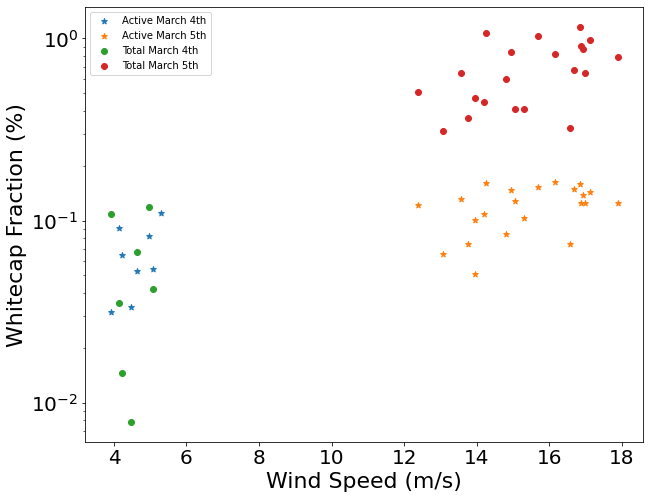

In [77]:
from pylab import *

wf_4l = np.array(wf_4l_20min[0:8])
wf_4l_active = np.array(wf_20min_active_4l)
wf_5l = np.array(wf_5l_20min)
wf_5l_active = np.array(wf_20min_active_5l)

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.set_yscale("log")
plt.scatter(wp_20_4l_active, wf_4l_active*100, marker = '*')
plt.scatter(wp_20_5l_active, wf_5l_active*100, marker = '*')
plt.scatter(wp_20_4l, wf_4l*100, marker = 'o')
plt.scatter(wp_20_5l, wf_5l*100, marker = 'o')

ax.set_ylabel("Whitecap Fraction (%)",fontsize=22)
ax.set_xlabel("Wind Speed (m/s)",fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
legend(["Active March 4th", "Active March 5th", "Total March 4th", "Total March 5th"])

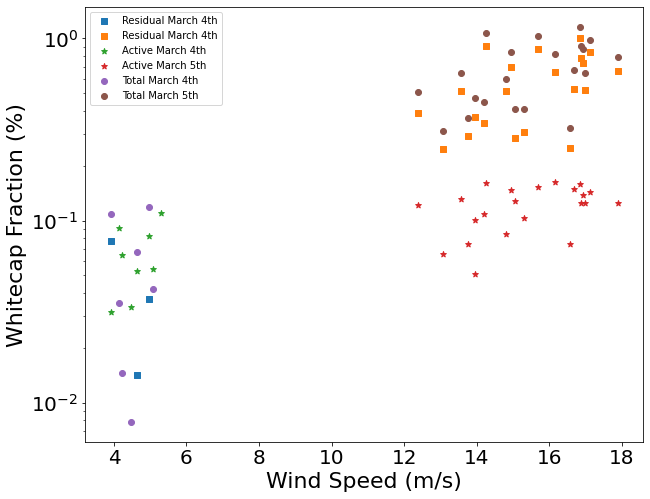

In [78]:
from pylab import *

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.set_yscale("log")

plt.scatter(wp_20_4l_active, (wf_4l-wf_4l_active)*100, marker = 's')
plt.scatter(wp_20_5l_active, (wf_5l-wf_5l_active)*100, marker = 's')

plt.scatter(wp_20_4l_active, wf_4l_active*100, marker = '*')
plt.scatter(wp_20_5l_active, wf_5l_active*100, marker = '*')
plt.scatter(wp_20_4l, wf_4l*100, marker = 'o')
plt.scatter(wp_20_5l, wf_5l*100, marker = 'o')

ax.set_ylabel("Whitecap Fraction (%)",fontsize=22)
ax.set_xlabel("Wind Speed (m/s)",fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
legend(["Residual March 4th", "Residual March 4th",
        "Active March 4th", "Active March 5th", 
        "Total March 4th", "Total March 5th"])

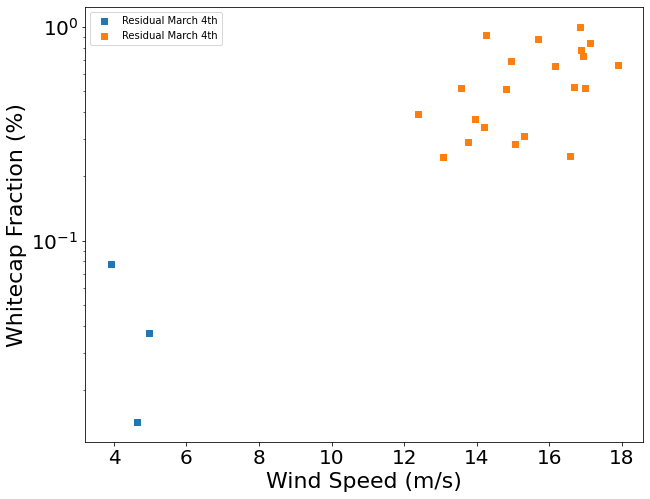

In [79]:
from pylab import *

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.set_yscale("log")

plt.scatter(wp_20_4l_active, (wf_4l-wf_4l_active)*100, marker = 's')
plt.scatter(wp_20_5l_active, (wf_5l-wf_5l_active)*100, marker = 's')



ax.set_ylabel("Whitecap Fraction (%)",fontsize=22)
ax.set_xlabel("Wind Speed (m/s)",fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
legend(["Residual March 4th", "Residual March 4th"])

In [8]:
aaa = pd.read_csv("E:/GoPro_1Hz_Unet_output/2020_3_4/GH010004_active.csv")

In [9]:
aaa

,Unnamed: 0,date,camera,video,image_fname,active_whitecaps,active_whitecaps_fraction,predict_image
0,0,2020_3_4_GoPro,image_left,GH010004.MP4,original_frame1.jpg,[[240 426]\n [241 426]\n [242 426]\n [299 417]...,0.000253,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....
1,1,2020_3_4_GoPro,image_left,GH010004.MP4,original_frame2.jpg,[[300 502]\n [330 393]\n [331 393]\n [331 402]...,0.000275,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....
2,2,2020_3_4_GoPro,image_left,GH010004.MP4,original_frame3.jpg,[[229 359]\n [230 359]\n [231 359]\n [232 359]...,0.001211,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....
3,3,2020_3_4_GoPro,image_left,GH010004.MP4,original_frame4.jpg,[[210 581]\n [210 582]\n [211 581]\n [211 582]...,0.000552,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....
4,4,2020_3_4_GoPro,image_left,GH010004.MP4,original_frame5.jpg,[[258 545]\n [258 546]\n [259 544]\n [259 545]...,0.000865,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....
...,...,...,...,...,...,...,...,...
526,526,2020_3_4_GoPro,image_left,GH010004.MP4,original_frame527.jpg,[[165 290]\n [165 291]\n [165 292]\n [166 290]...,0.000725,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....
527,527,2020_3_4_GoPro,image_left,GH010004.MP4,original_frame528.jpg,[[299 325]\n [300 325]\n [300 326]\n [301 326]...,0.001066,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....
528,528,2020_3_4_GoPro,image_left,GH010004.MP4,original_frame529.jpg,[[278 285]\n [278 286]\n [279 285]\n [279 286]...,0.002619,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....
529,529,2020_3_4_GoPro,image_left,GH010004.MP4,original_frame530.jpg,[[258 485]\n [259 484]\n [259 485]\n [260 484]...,0.000181,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....


In [18]:
aaa[['active_whitecaps_fraction', 'video']]

,active_whitecaps_fraction,video
0,0.000253,GH010004.MP4
1,0.000275,GH010004.MP4
2,0.001211,GH010004.MP4
3,0.000552,GH010004.MP4
4,0.000865,GH010004.MP4
...,...,...
526,0.000725,GH010004.MP4
527,0.001066,GH010004.MP4
528,0.002619,GH010004.MP4
529,0.000181,GH010004.MP4
